In [ ]:
!apt install subversion
!svn checkout https://github.com/ChanCheeKean/datasets/trunk/images/mobile_net

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# 1) Data Loading

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "mobile_net"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 3 classes.
Using 262 files for training.
Found 327 files belonging to 3 classes.
Using 65 files for validation.


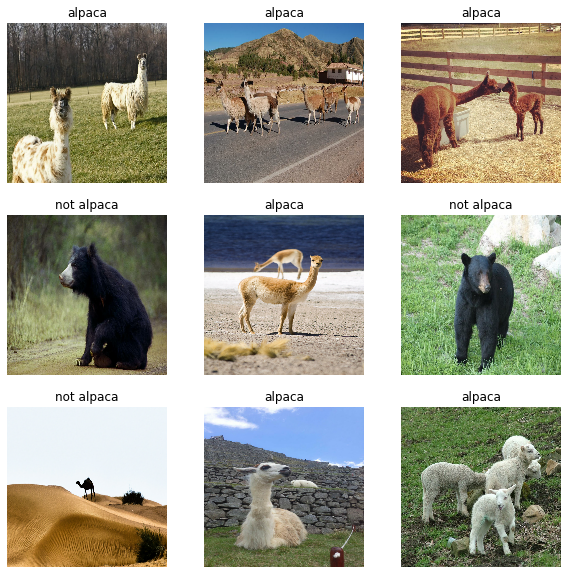

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2) Data Augmentation

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))    
    return data_augmentation

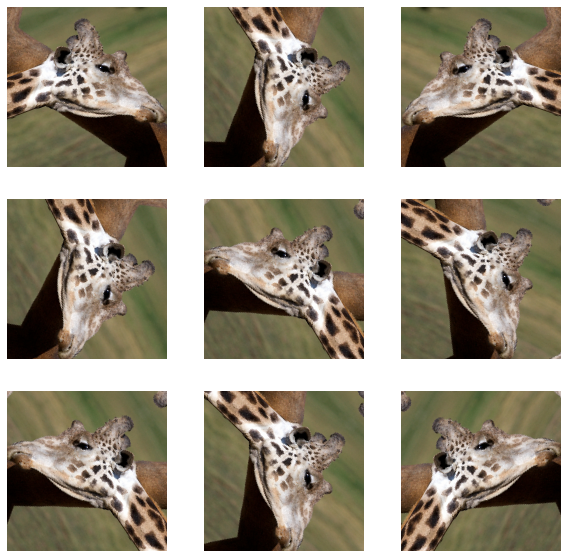

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 3) MobileNet 

https://sahiltinky94.medium.com/know-about-mobilenet-v1-implementation-from-scratch-using-pytorch-7dd594f4d99b

https://towardsdatascience.com/building-mobilenet-from-scratch-using-tensorflow-ad009c5dd42c

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

<img src="https://github.com/Zeriet/Deep-Learning-Specialization/blob/main/Convolutional%20Neural%20Networks/Transfer_learning_with_MobileNet_v1/images/mobilenetv2.png?raw=true" style="width:650px;height:450px;">
<caption><center> <u> <b>Figure 1</b> </u>: <b>MobileNetV2 Architecture</b>



In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=True, weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
# base_model.summary()

In [ ]:
# The last 2 layers are the so called top layers, and they are responsible of the classification in the model
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


<font color='blue'>

**What you should remember**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
label_batch

(32, 1000)


<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int32)>

Shape of the batch = (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.20592251),
  ('n02317335', 'starfish', 0.10664826)],
 [('n04589890', 'window_screen', 0.31899592),
  ('n03598930', 'jigsaw_puzzle', 0.19315615)],
 [('n04589890', 'window_screen', 0.28256148),
  ('n06359193', 'web_site', 0.066800386)],
 [('n04589890', 'window_screen', 0.4884121),
  ('n03530642', 'honeycomb', 0.09111891)],
 [('n04589890', 'window_screen', 0.6286293),
  ('n03530642', 'honeycomb', 0.060480494)],
 [('n03598930', 'jigsaw_puzzle', 0.09978527),
  ('n01694178', 'African_chameleon', 0.048828054)],
 [('n04589890', 'window_screen', 0.8180045),
  ('n03598930', 'jigsaw_puzzle', 0.014480496)],
 [('n04589890', 'window_screen', 0.5053745),
  ('n03530642', 'honeycomb', 0.032941923)],
 [('n04589890', 'window_screen', 0.63768446),
  ('n03530642', 'honeycomb', 0.029194068)],
 [('n04589890', 'window_screen', 0.7454777),
  ('n04209239', 'shower_curtain', 0.033879403)],
 [('n03291819', 'envelope', 0.21836446),
  ('n06359193', 'web_site', 0.18764776)],
 [('n0

None of them say "alpaca". This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

We can delete the top layer, which contains all the classification labels, and create a new classification layer.

# 4) Re-train Model

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top = False, weights="imagenet")
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer =  tf.keras.layers.Dense(1, activation='linear')    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 30s 3s/step - loss: 0.5999 - accuracy: 0.6718 - val_loss: 0.1482 - val_accuracy: 0.9385
Epoch 2/5
9/9 [==============================] - 6s 514ms/step - loss: 0.2826 - accuracy: 0.8626 - val_loss: 0.2379 - val_accuracy: 0.8308
Epoch 3/5
9/9 [==============================] - 6s 522ms/step - loss: 0.3530 - accuracy: 0.8359 - val_loss: 0.0651 - val_accuracy: 0.9846
Epoch 4/5
9/9 [==============================] - 6s 511ms/step - loss: 0.2748 - accuracy: 0.8817 - val_loss: 0.0595 - val_accuracy: 0.9846
Epoch 5/5
9/9 [==============================] - 6s 515ms/step - loss: 0.1936 - accuracy: 0.9237 - val_loss: 0.0625 - val_accuracy: 1.0000


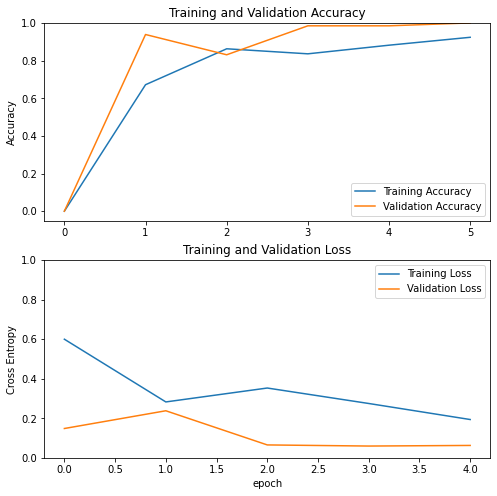

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 5) Model Fine Tuning

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 120
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1 * base_learning_rate)
metrics =  ['accuracy']  

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 598ms/step - loss: 0.1818 - accuracy: 0.9122 - val_loss: 0.0599 - val_accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 6s 522ms/step - loss: 0.1447 - accuracy: 0.9427 - val_loss: 0.0618 - val_accuracy: 0.9846
Epoch 7/10
9/9 [==============================] - 6s 513ms/step - loss: 0.1837 - accuracy: 0.9198 - val_loss: 0.0611 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 6s 510ms/step - loss: 0.1734 - accuracy: 0.9160 - val_loss: 0.0613 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 6s 506ms/step - loss: 0.1700 - accuracy: 0.9160 - val_loss: 0.0599 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 6s 509ms/step - loss: 0.1712 - accuracy: 0.9313 - val_loss: 0.0590 - val_accuracy: 0.9846


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

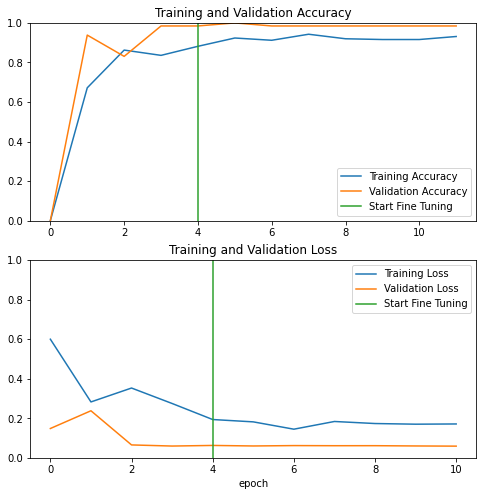

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 